# Prédiction du prix de clôture d'une action avec LSTM

L'objectif de ce TP est de prédire le comportement du prix de clôture d'une seule entreprise en prédisant les `n` prochains jours (`forward_days`), en utilisant comme entrée les `m` jours précédents (`look_back`).

### importe les bibliothèques nécessaires

In [ ]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM,Dense
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from keras.models import load_model

In [ ]:
# Nombre de jours précédents utilisés comme entrée pour prédire le prix de clôture
look_back = 40
# Nombre de jours à prédire dans le futur
forward_days = 10
# Nombre de périodes à utiliser pour l'entraînement et le test du modèle
num_periods = 20

# Préparation des données

In [ ]:
#open the csv, chose company_N, where N = {A, B, C or D}
df = pd.read_csv('company_A.csv')
#set date as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
#keep only the 'Close' column
df = df['Close']

df.head()

Date
2010-01-08    30.282858
2010-01-11    30.015715
2010-01-12    29.674286
2010-01-13    30.092857
2010-01-14    29.918571
Name: Close, dtype: float64

# La visualisation des données

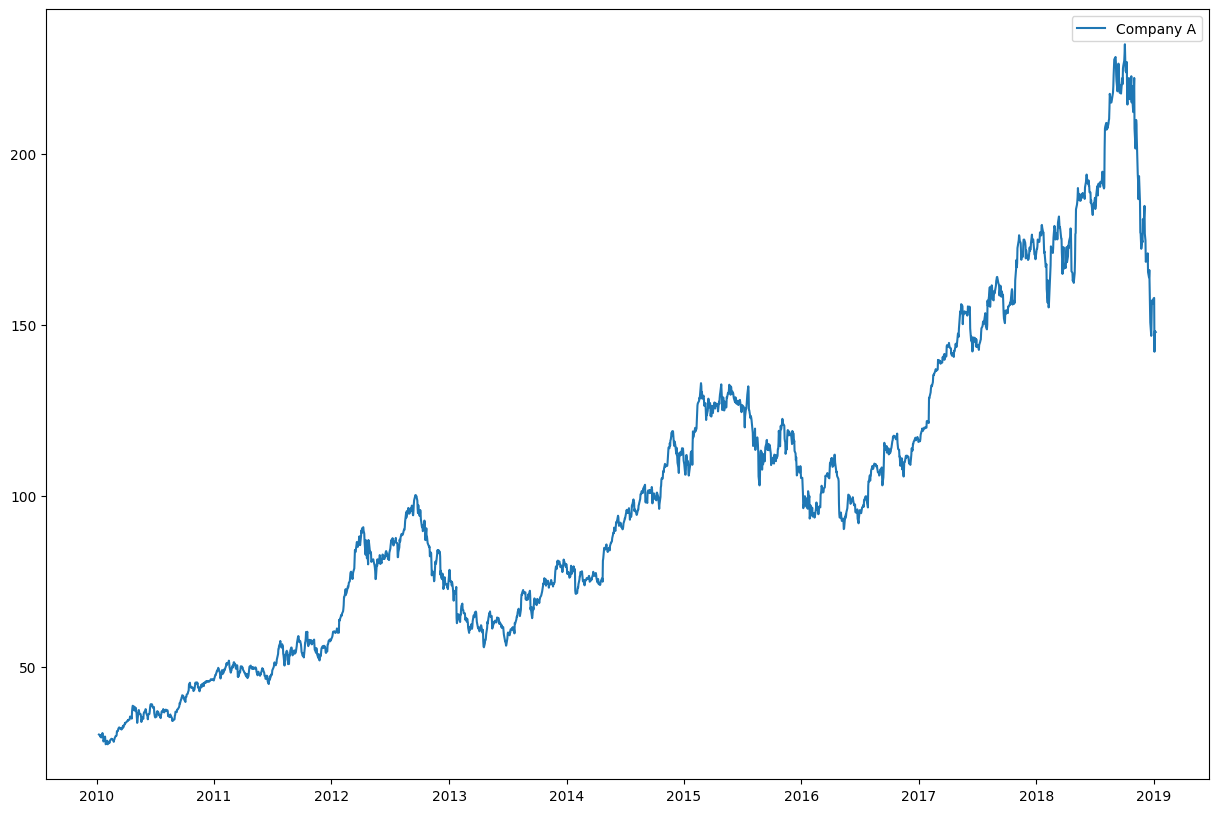

In [ ]:
plt.figure(figsize = (15,10))
plt.plot(df, label='Company A')
plt.legend(loc='best')
plt.show()

# La normalisation des données

In [ ]:
array = df.values.reshape(df.shape[0],1)
array[:5]

array([[30.282858],
       [30.015715],
       [29.674286],
       [30.092857],
       [29.918571]])

In [ ]:
scl = MinMaxScaler()
array = scl.fit_transform(array)
array[:5]

array([[0.01391332],
       [0.01260786],
       [0.01093937],
       [0.01298483],
       [0.01213314]])

# Séparer les données en données d'entraînement/validation du LSTM et données de test du modèle




L'ensemble de test sera composé des `k` dernières périodes (`num_periods`) sur lesquelles nous voulons tester le modèle. Pour chaque période, le modèle prédira les n jours suivants. Les données restantes seront utilisées pour l'entraînement et la validation.



In [ ]:
division = len(array) - num_periods*forward_days
array_test = array[division-look_back:]
array_train = array[:division]

### Récupère les données et les divise en entrée X et sortie Y, en séparant les `n` jours précédents en tant qu'entrée X et les `m` jours suivants en tant que Y.

In [ ]:

def processData(data, look_back, forward_days,jump=1):
    X,Y = [],[]
    for i in range(0,len(data) -look_back -forward_days +1, jump):
        X.append(data[i:(i+look_back)])
        Y.append(data[(i+look_back):(i+look_back+forward_days)])
    return np.array(X),np.array(Y)

In [ ]:
X_test,y_test = processData(array_test,look_back,forward_days,forward_days)
y_test = np.array([list(a.ravel()) for a in y_test])

X,y = processData(array_train,look_back,forward_days)
y = np.array([list(a.ravel()) for a in y])

from sklearn.model_selection import train_test_split
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
print(X_train.shape)
print(X_validate.shape)
print(X_test.shape)
print(y_train.shape)
print(y_validate.shape)
print(y_test.shape)

(1612, 40, 1)
(403, 40, 1)
(20, 40, 1)
(1612, 10)
(403, 10)
(20, 10)


# Création d'un modèle de réseau de neurones LSTM pour la prédiction de séries temporelles

In [ ]:
NUM_NEURONS_FirstLayer = 50
NUM_NEURONS_SecondLayer = 30
EPOCHS = 50


model = Sequential()
model.add(LSTM(NUM_NEURONS_FirstLayer,input_shape=(look_back,1), return_sequences=True))
model.add(LSTM(NUM_NEURONS_SecondLayer,input_shape=(NUM_NEURONS_FirstLayer,1)))
model.add(Dense(forward_days))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train,y_train,epochs=EPOCHS,validation_data=(X_validate,y_validate),shuffle=True,batch_size=2, verbose=2)

Epoch 1/50
806/806 - 9s - loss: 0.0026 - val_loss: 5.9112e-04 - 9s/epoch - 11ms/step
Epoch 2/50
806/806 - 6s - loss: 7.4454e-04 - val_loss: 5.2217e-04 - 6s/epoch - 7ms/step
Epoch 3/50
806/806 - 5s - loss: 6.6244e-04 - val_loss: 4.4510e-04 - 5s/epoch - 6ms/step
Epoch 4/50
806/806 - 6s - loss: 5.7285e-04 - val_loss: 9.5219e-04 - 6s/epoch - 7ms/step
Epoch 5/50
806/806 - 5s - loss: 5.4661e-04 - val_loss: 4.2492e-04 - 5s/epoch - 6ms/step
Epoch 6/50
806/806 - 6s - loss: 4.7425e-04 - val_loss: 6.0882e-04 - 6s/epoch - 8ms/step
Epoch 7/50
806/806 - 6s - loss: 4.6932e-04 - val_loss: 3.6178e-04 - 6s/epoch - 8ms/step
Epoch 8/50
806/806 - 5s - loss: 4.2978e-04 - val_loss: 4.8446e-04 - 5s/epoch - 6ms/step
Epoch 9/50
806/806 - 6s - loss: 4.7609e-04 - val_loss: 3.5457e-04 - 6s/epoch - 7ms/step
Epoch 10/50
806/806 - 5s - loss: 4.0018e-04 - val_loss: 3.5953e-04 - 5s/epoch - 6ms/step
Epoch 11/50
806/806 - 6s - loss: 4.3023e-04 - val_loss: 3.5019e-04 - 6s/epoch - 7ms/step
Epoch 12/50
806/806 - 5s - loss: 

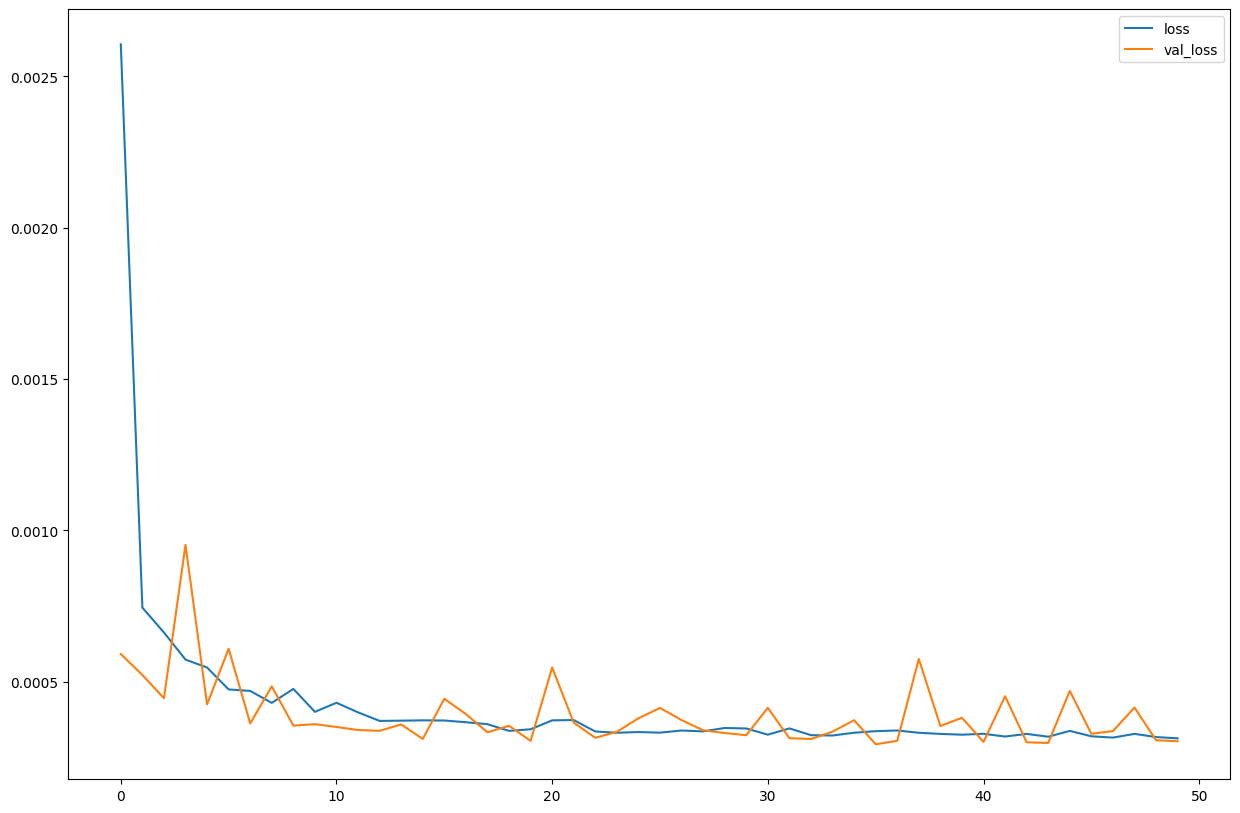

In [ ]:
plt.figure(figsize = (15,10))

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='best')
plt.show()

# Prédiction de l'ensemble de test pour observer les résultats.

In [ ]:
Xt = model.predict(X_test)

1/1 [==============================] - 1s 866ms/step


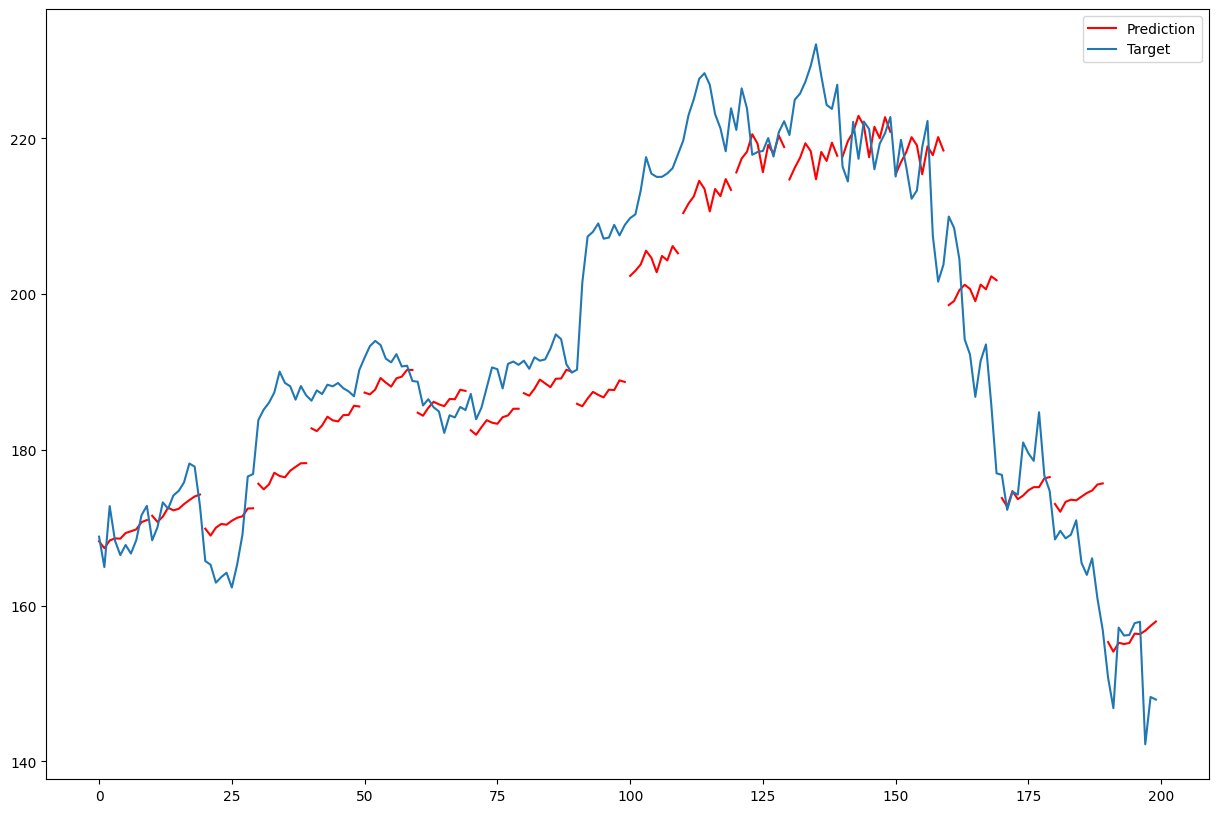

In [ ]:
plt.figure(figsize = (15,10))

for i in range(0,len(Xt)):
    plt.plot([x + i*forward_days for x in range(len(Xt[i]))], scl.inverse_transform(Xt[i].reshape(-1,1)), color='r')

plt.plot(0, scl.inverse_transform(Xt[i].reshape(-1,1))[0], color='r', label='Prediction')

plt.plot(scl.inverse_transform(y_test.reshape(-1,1)), label='Target')
plt.legend(loc='best')
plt.show()

### Prédiction de l'ensemble complet des données pour observer la réaction du modèle aux ensembles d'entraînement et de test.


In [ ]:
division = len(array) - num_periods*forward_days

leftover = division%forward_days+1

array_test = array[division-look_back:]
array_train = array[leftover:division]

In [ ]:
Xtrain,ytrain = processData(array_train,look_back,forward_days,forward_days)
Xtest,ytest = processData(array_test,look_back,forward_days,forward_days)

In [ ]:
Xtrain = model.predict(Xtrain)
Xtrain = Xtrain.ravel()

Xtest = model.predict(Xtest)
Xtest = Xtest.ravel()

1/1 [==============================] - 0s 32ms/step


In [ ]:
y = np.concatenate((ytrain, ytest), axis=0)

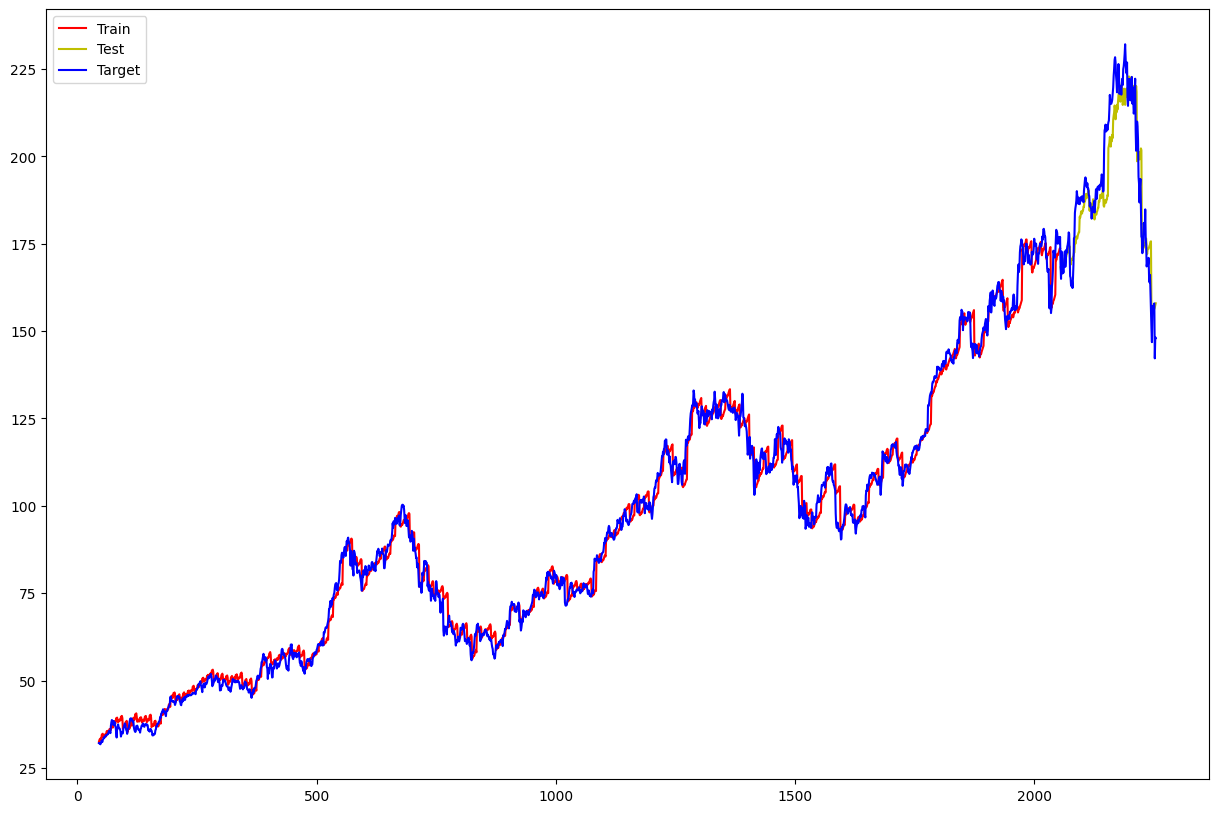

In [ ]:
plt.figure(figsize = (15,10))

# Data in Train/Validation
plt.plot([x for x in range(look_back+leftover, len(Xtrain)+look_back+leftover)], scl.inverse_transform(Xtrain.reshape(-1,1)), color='r', label='Train')
# Data in Test
plt.plot([x for x in range(look_back +leftover+ len(Xtrain), len(Xtrain)+len(Xtest)+look_back+leftover)], scl.inverse_transform(Xtest.reshape(-1,1)), color='y', label='Test')

#Data used
plt.plot([x for x in range(look_back+leftover, look_back+leftover+len(Xtrain)+len(Xtest))], scl.inverse_transform(y.reshape(-1,1)), color='b', label='Target')

#Initial data. It should overlap the data used
#plt.plot(scl.inverse_transform(array), color='b', label='Esperado')

plt.legend(loc='best')
plt.show()

### En analysant les résultats, il est remarquable que le modèle a réussi à prédire avec succès les données. Cela démontre l'efficacité et la capacité du modèle LSTM à capturer les motifs et les tendances des séries temporelles. Les prédictions précises obtenues renforcent la confiance dans le modèle et suggèrent qu'il peut être utilisé pour des prédictions futures avec une certaine fiabilité.

# Voir d'autres résultats en utilisant d'autres jeux de données

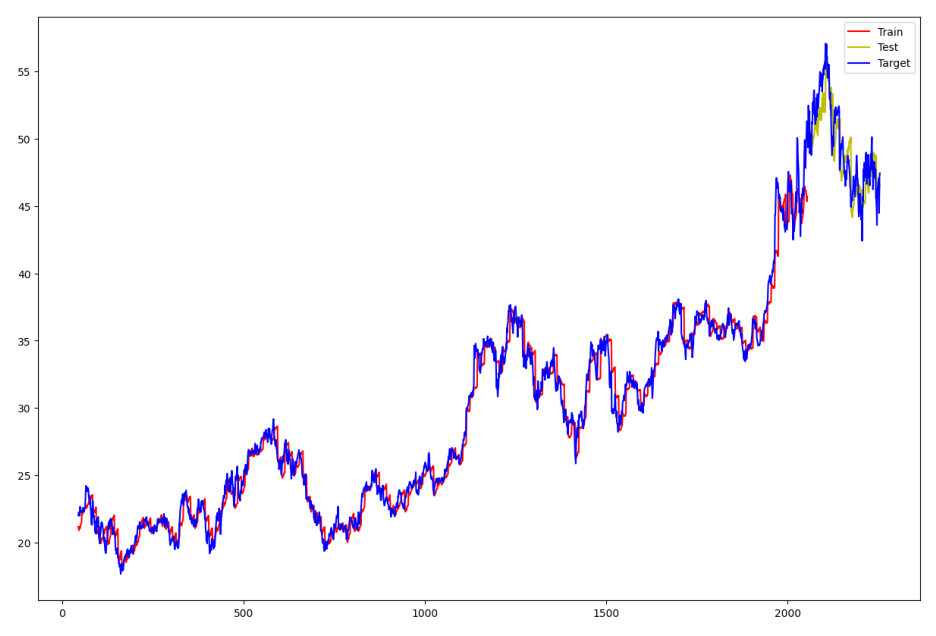

In [7]:
import cv2
import matplotlib.pyplot as plt

# Load the image from a URL or local file
image_url = 'result_datase_C.png'  # Replace with your image URL or file path
image = cv2.imread(image_url)

# Convert the image from BGR to RGB color format
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Set the figure size for larger display
plt.figure(figsize=(12, 8))

# Display the image using matplotlib
plt.imshow(image)
plt.axis('off')  # Turn off axis labels
plt.show()

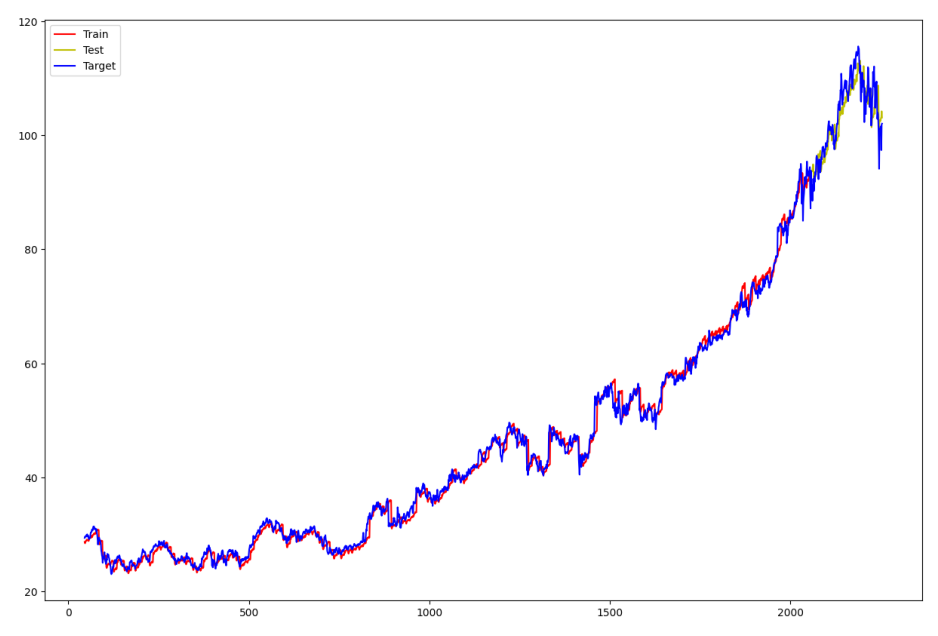

In [9]:
import cv2
import matplotlib.pyplot as plt

# Load the image from a URL or local file
image_url = 'result_dataset_B.png'  # Replace with your image URL or file path
image = cv2.imread(image_url)

# Convert the image from BGR to RGB color format
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Set the figure size for larger display
plt.figure(figsize=(12, 8))

# Display the image using matplotlib
plt.imshow(image)
plt.axis('off')  # Turn off axis labels
plt.show()

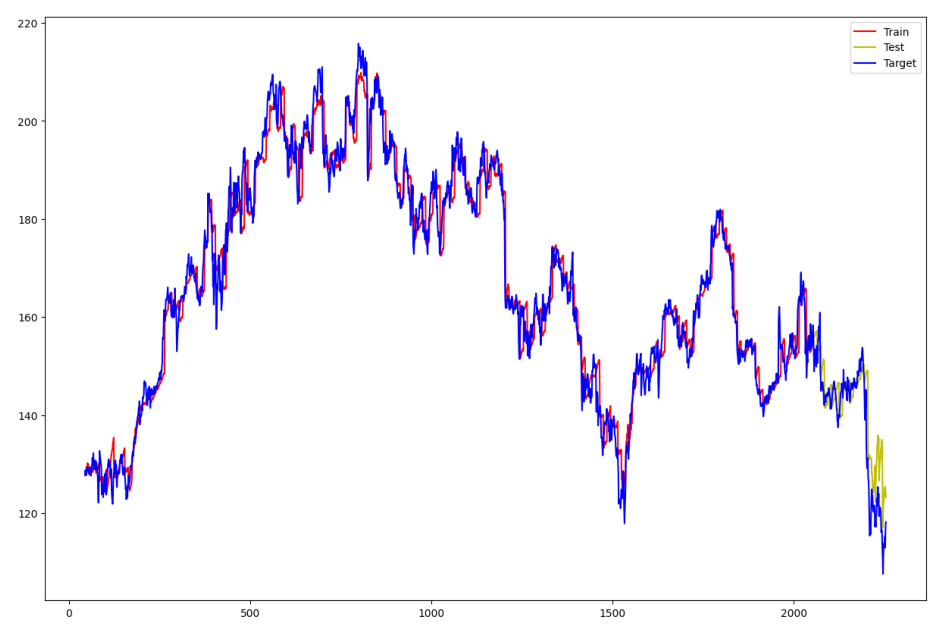

In [10]:
import cv2
import matplotlib.pyplot as plt

# Load the image from a URL or local file
image_url = 'result_dataset_D.png'  # Replace with your image URL or file path
image = cv2.imread(image_url)

# Convert the image from BGR to RGB color format
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Set the figure size for larger display
plt.figure(figsize=(12, 8))

# Display the image using matplotlib
plt.imshow(image)
plt.axis('off')  # Turn off axis labels
plt.show()